# 주식채권현금 평균모멘텀스코어 분산투자 한국 그림 2-33
- 투자 기간 : 2002년 1월~2017월 6일
- 투자 대상 : 코스피200지수, 10년 만기 국고채 지수, 20년 만기 국고채 지수, 현금(3년 만기 국고채 지수)
- 매수 규칙 : 주식:채권:현금=코스피200지수 최근 12개월 평균 모멘텀 스코어 10년(20년) 만기 국고채 지수 최근 12개월 평균 모멘텀 스코어 : 1(현금 모멘텀)
- 매도 규칙 : 매달 말 위의 투자 비중을 새로 계산하여 주식:채권:현금 투자 비중을 조절하여 반복
- 동일 비중 
  - 20년 국채 9.1%/-15.1%

In [1]:
from settings import *

## 데이타 읽기

In [2]:
tickers = ['kodex200', 'kbond3y', 'kbond10y', 'kbond20y']
read_df = get_data()
read_df = read_df[tickers]
read_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5433 non-null   float64
 1   kbond3y   5433 non-null   float64
 2   kbond10y  5433 non-null   float64
 3   kbond20y  5433 non-null   float64
dtypes: float64(4)
memory usage: 212.2 KB


In [3]:
data = read_df['2001':].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5192 entries, 2001-01-02 to 2021-12-30
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5192 non-null   float64
 1   kbond3y   5192 non-null   float64
 2   kbond10y  5192 non-null   float64
 3   kbond20y  5192 non-null   float64
dtypes: float64(4)
memory usage: 202.8 KB


In [17]:
start = '2002-02-01'
s = "2001-1-2"
e = '2017-6-30'

## 전략 Class 생성

In [4]:
class WeighAverageMomentumScoreIncludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12):
        super(WeighAverageMomentumScoreIncludeCash, self).__init__()
        self.lookback = lookback

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights = weights/weights.sum()

        target.temp['weights'] = weights

        return True

## 전략 생성

날짜 차이를 잘 고려해서 본인에 맞는 전략을 구현해야 함

월초에 리밸런싱하고 전달 말일을 기준으로 한다면 위의 소스도 맞지 않음.

말일에 맞게 t0를 수정하면 월초에 사용할 수 없음.

=> 전략간 비교를 위해 월초 리밸런싱할 건지 월말 리밸런싱할 건지를 정하고 동일하게 비교하는 것이 맞는 듯

In [5]:
def average_momentum_score_strategy(name, data, tickers, months=12):
    st = bt.Strategy(name,
        [
            bt.algos.RunMonthly(), # 월초
            bt.algos.SelectThese(tickers),
            WeighAverageMomentumScoreIncludeCash(months),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(st, data, initial_capital=100000000)

## 전략 실행

In [6]:
bt_kospi = long_only_ew(data, ['kodex200'], 'kodex200')
bt_ew = long_only_ew(data, ['kodex200', 'kbond20y', 'kbond3y'], "코스피200+20년국채+현금(동일비중)")
bt_10 = average_momentum_score_strategy('코스피200+10년국채+현금', data, 
                                        ['kodex200', 'kbond3y', 'kbond10y'])
bt_20 = average_momentum_score_strategy('코스피200+20년국채+현금', data, 
                                        ['kodex200', 'kbond3y', 'kbond20y'])

r10 = bt.run(bt_10)


prc : 2001-01-02 00:00:00 2000-12 ~ 1999-12
2001-01-02 00:00:00 not yet data


prc : 2001-02-01 00:00:00 2001-01 ~ 2000-01
2001-02-01 00:00:00 not yet data


prc : 2001-03-02 00:00:00 2001-02 ~ 2000-02
2001-03-02 00:00:00 not yet data


prc : 2001-04-02 00:00:00 2001-03 ~ 2000-03
2001-04-02 00:00:00 not yet data


prc : 2001-05-02 00:00:00 2001-04 ~ 2000-04
2001-05-02 00:00:00 not yet data


prc : 2001-06-01 00:00:00 2001-05 ~ 2000-05
2001-06-01 00:00:00 not yet data


prc : 2001-07-02 00:00:00 2001-06 ~ 2000-06
2001-07-02 00:00:00 not yet data


prc : 2001-08-01 00:00:00 2001-07 ~ 2000-07
2001-08-01 00:00:00 not yet data


prc : 2001-09-03 00:00:00 2001-08 ~ 2000-08
2001-09-03 00:00:00 not yet data


prc : 2001-10-04 00:00:00 2001-09 ~ 2000-09
2001-10-04 00:00:00 not yet data


prc : 2001-11-01 00:00:00 2001-10 ~ 2000-10
2001-11-01 00:00:00 not yet data


prc : 2001-12-03 00:00:00 2001-11 ~ 2000-11
2001-12-03 00:00:00 not yet data


prc : 2002-01-02 00:00:00 2001-12 ~ 2000-12
2002-01

In [7]:
r20 = bt.run(bt_20)
r_kospi = bt.run(bt_kospi)
r_ew = bt.run(bt_ew)
r = bt.run(bt_10, bt_20, bt_kospi, bt_ew)


prc : 2001-01-02 00:00:00 2000-12 ~ 1999-12
2001-01-02 00:00:00 not yet data


prc : 2001-02-01 00:00:00 2001-01 ~ 2000-01
2001-02-01 00:00:00 not yet data


prc : 2001-03-02 00:00:00 2001-02 ~ 2000-02
2001-03-02 00:00:00 not yet data


prc : 2001-04-02 00:00:00 2001-03 ~ 2000-03
2001-04-02 00:00:00 not yet data


prc : 2001-05-02 00:00:00 2001-04 ~ 2000-04
2001-05-02 00:00:00 not yet data


prc : 2001-06-01 00:00:00 2001-05 ~ 2000-05
2001-06-01 00:00:00 not yet data


prc : 2001-07-02 00:00:00 2001-06 ~ 2000-06
2001-07-02 00:00:00 not yet data


prc : 2001-08-01 00:00:00 2001-07 ~ 2000-07
2001-08-01 00:00:00 not yet data


prc : 2001-09-03 00:00:00 2001-08 ~ 2000-08
2001-09-03 00:00:00 not yet data


prc : 2001-10-04 00:00:00 2001-09 ~ 2000-09
2001-10-04 00:00:00 not yet data


prc : 2001-11-01 00:00:00 2001-10 ~ 2000-10
2001-11-01 00:00:00 not yet data


prc : 2001-12-03 00:00:00 2001-11 ~ 2000-11
2001-12-03 00:00:00 not yet data


prc : 2002-01-02 00:00:00 2001-12 ~ 2000-12
2002-01

In [9]:
r.set_date_range(start)
r.display()

Stat                 코스피200+10년국채+현금    코스피200+20년국채+현금    kodex200    코스피200+20년국채+현금(동일비중)
-------------------  -------------------------  -------------------------  ----------  -----------------------------------
Start                2002-02-01                 2002-02-01                 2002-02-01  2002-02-01
End                  2021-12-30                 2021-12-30                 2021-12-30  2021-12-30
Risk-free rate       0.00%                      0.00%                      0.00%       0.00%

Total Return         256.30%                    358.22%                    511.99%     352.09%
Daily Sharpe         1.03                       1.09                       0.53        0.80
Daily Sortino        1.64                       1.77                       0.85        1.30
CAGR                 6.59%                      7.95%                      9.53%       7.87%
Max Drawdown         -10.37%                    -10.70%                    -52.67%     -28.82%
Calmar Ratio         0.64  

In [10]:
r.prices

,코스피200+10년국채+현금,코스피200+20년국채+현금,kodex200,코스피200+20년국채+현금(동일비중)
2002-02-01,100.000,100.000,144.036,119.368
2002-02-04,99.458,99.408,141.797,118.849
2002-02-05,100.130,100.166,143.876,119.784
2002-02-06,100.169,100.206,144.086,119.807
2002-02-07,99.428,99.382,141.397,118.924
...,...,...,...,...
2021-12-24,357.517,460.386,886.904,542.475
2021-12-27,357.494,460.533,881.709,541.208
2021-12-28,357.988,461.251,888.894,543.560
2021-12-29,358.155,461.334,886.904,543.096


In [11]:
r.prices.resample('MS').first().to_drawdown_series().describe()

,코스피200+10년국채+현금,코스피200+20년국채+현금,kodex200,코스피200+20년국채+현금(동일비중)
count,239.000,239.000,239.000,239.000
mean,-0.016,-0.015,-0.103,-0.023
std,0.020,0.023,0.092,0.039
min,-0.078,-0.098,-0.468,-0.244
25%,-0.028,-0.022,-0.147,-0.030
50%,-0.005,-0.002,-0.096,-0.009
75%,0.000,0.000,-0.021,0.000
max,0.000,0.000,0.000,0.000


In [12]:
r.set_date_range(start, e)
r.display()

Stat                 코스피200+10년국채+현금    코스피200+20년국채+현금    kodex200    코스피200+20년국채+현금(동일비중)
-------------------  -------------------------  -------------------------  ----------  -----------------------------------
Start                2002-02-01                 2002-02-01                 2002-02-01  2002-02-01
End                  2017-06-30                 2017-06-30                 2017-06-30  2017-06-30
Risk-free rate       0.00%                      0.00%                      0.00%       0.00%

Total Return         208.16%                    282.46%                    341.90%     267.54%
Daily Sharpe         1.23                       1.26                       0.55        0.86
Daily Sortino        1.98                       2.07                       0.87        1.40
CAGR                 7.58%                      9.10%                      10.12%      8.81%
Max Drawdown         -8.81%                     -10.59%                    -52.67%     -28.82%
Calmar Ratio         0.86  

In [13]:
r.prices

,코스피200+10년국채+현금,코스피200+20년국채+현금,kodex200,코스피200+20년국채+현금(동일비중)
2002-02-01,100.000,100.000,144.036,119.368
2002-02-04,99.458,99.408,141.797,118.849
2002-02-05,100.130,100.166,143.876,119.784
2002-02-06,100.169,100.206,144.086,119.807
2002-02-07,99.428,99.382,141.397,118.924
...,...,...,...,...
2017-06-26,308.501,383.239,635.901,440.512
2017-06-27,308.387,383.257,636.078,440.720
2017-06-28,307.727,382.056,634.088,438.729
2017-06-29,308.715,383.272,638.466,440.029


In [14]:
r.prices.resample('MS').first().to_drawdown_series().describe()

,코스피200+10년국채+현금,코스피200+20년국채+현금,kodex200,코스피200+20년국채+현금(동일비중)
count,185.000,185.000,185.000,185.000
mean,-0.011,-0.013,-0.107,-0.025
std,0.017,0.022,0.096,0.043
min,-0.078,-0.098,-0.468,-0.244
25%,-0.017,-0.017,-0.147,-0.030
50%,-0.002,-0.000,-0.098,-0.008
75%,0.000,0.000,-0.022,0.000
max,0.000,0.000,0.000,0.000


## 그림 2-33

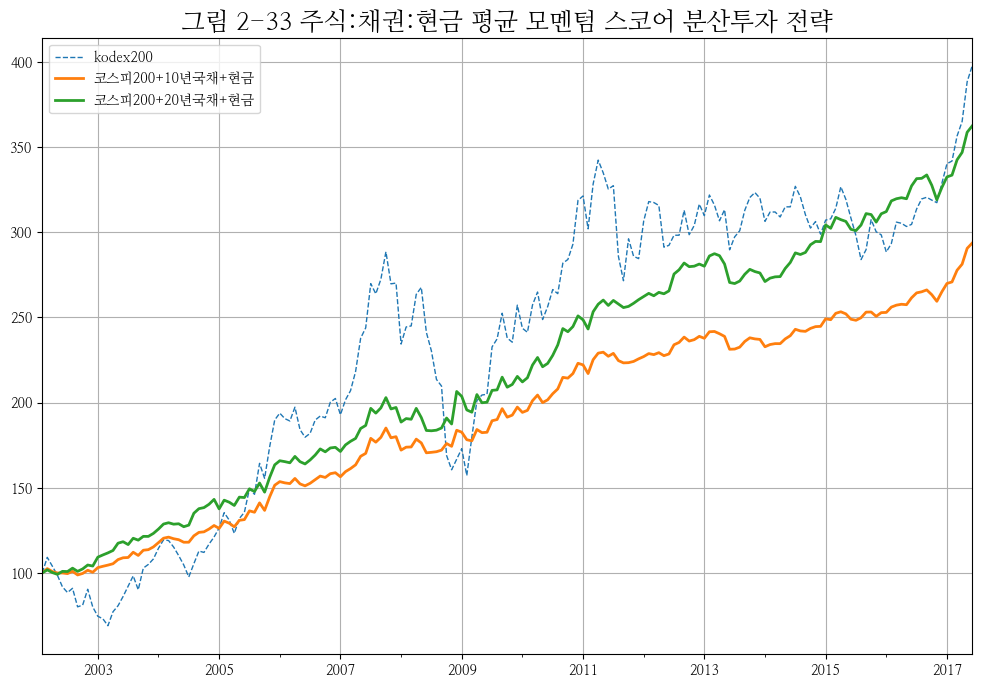

In [23]:
r_kospi.set_date_range(start,e)
r10.set_date_range(start,e)
r20.set_date_range(start,e)

ax1 = r_kospi.plot(freq='M', ls='--', figsize=(12, 8));
r10.plot(ax=ax1, freq='M', lw=2, figsize=(12, 8));
r20.plot(ax=ax1, freq='M', lw=2, figsize=(12, 8));
plt.title("그림 2-33 주식:채권:현금 평균 모멘텀 스코어 분산투자 전략", fontsize=18);

                        CAGR
코스피200+10년국채+현금        7.577
코스피200+20년국채+현금        9.096
kodex200              10.124
코스피200+20년국채+현금(동일비중)  8.815
                          MDD
코스피200+10년국채+현금        -8.805
코스피200+20년국채+현금       -10.588
kodex200              -52.666
코스피200+20년국채+현금(동일비중) -28.818


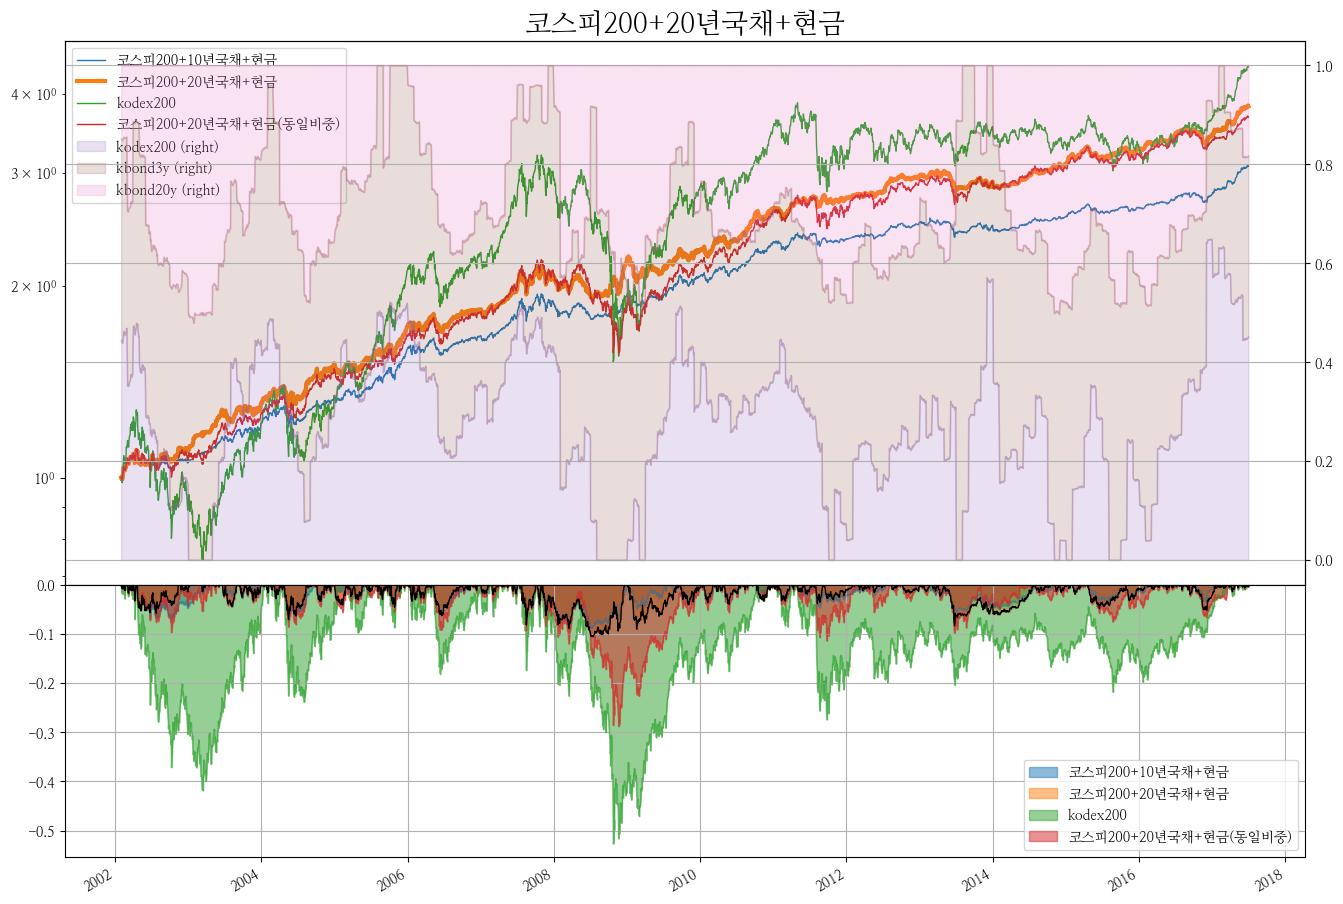

In [20]:
plot_assets(r, start, e, "코스피200+20년국채+현금")

## 그림 2-34

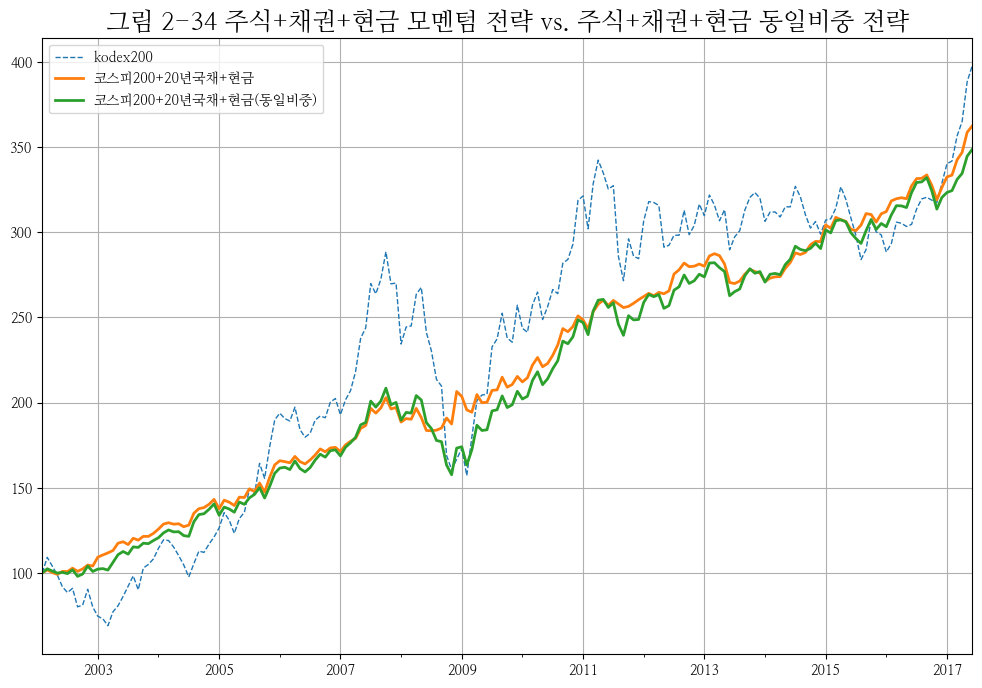

In [22]:
r_kospi.set_date_range(start,e)
r10.set_date_range(start,e)
r20.set_date_range(start,e)
r_ew.set_date_range(start,e)

ax1 = r_kospi.plot(freq='M', ls='--', figsize=(12, 8));
# r10.plot(ax=ax1, freq='M', lw=2, figsize=(12, 8));
r20.plot(ax=ax1, freq='M', lw=2, figsize=(12, 8));
r_ew.plot(ax=ax1, freq='M', lw=2, figsize=(12, 8));
plt.title("그림 2-34 주식+채권+현금 모멘텀 전략 vs. 주식+채권+현금 동일비중 전략", fontsize=18);